In [2]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

from src.cache import cache

set_matplotlib_formats("svg")

In [3]:
from src.models.instrumental_variable import get_covariances

get_covariances(instruments="weather_covid")

,cov_w,cov_y,wald
covid_residential_lag0,-0.012150,-68.888112,5669.630743
covid_workplaces_lag0,0.011558,69.031726,5972.543520
covid_transit_stations_lag0,0.009238,76.307897,8260.259585
covid_retail_and_recreation_lag0,0.009151,68.895663,7528.862787
weather_tmin_lag0,0.007102,38.692243,5447.946865
covid_parks_lag0,0.006466,47.846650,7399.448164
weather_tavg_lag0,0.004919,32.043264,6514.190883
covid_stringency_index_lag0,-0.004649,-56.437889,12140.182335
weather_wspd_lag0,-0.004630,-53.757987,11611.972075
weather_snow_lag0,-0.004074,-19.772385,4852.930762


In [4]:
from src.models.instrumental_variable import get_coefficients

get_coefficients("weather_covid")[0]

single               combi          
                                      coef      pval      coef      pval
covid_parks_lag0                  0.007399  0.000427  0.018361  0.003697
covid_grocery_and_pharmacy_lag0   0.002462  0.322549 -0.016634  0.004366
covid_workplaces_lag0             0.009365  0.000323  0.023269  0.005088
weather_wspd_lag0                -0.004464  0.029327 -0.008692  0.080421
weather_pres_lag0                -0.001924  0.336838 -0.003860  0.108943
weather_wpgt_lag0                -0.002440  0.228822  0.003555  0.460912
covid_stringency_index_lag0      -0.002725  0.223267 -0.003819  0.543408
weather_tmin_lag0                 0.005269  0.009826  0.008303  0.544655
weather_tsun_lag0                 0.002839  0.158879  0.002212  0.574665
covid_transit_stations_lag0       0.007607  0.001031 -0.006704  0.575280
weather_tmax_lag0                 0.005306  0.009763 -0.007860  0.691190
covid_retail_and_recreation_lag0  0.006390  0.004574 -0.002877  0.750704
weather_tavg_lag0                 0.005415  0.008133 -0.006334  0.827140
covid_residential_lag0           -0.009593  0.000037  0.000964  0.946339
weather_snow_lag0                -0.000943  0.635986 -0.000044  0.983521
weather_prcp_lag0                 0.000650  0.742007  0.000033  0.988522

In [5]:
get_coefficients("pc_weather_covid")[0]

single               combi          
           coef      pval      coef      pval
pc_0  -0.008100  0.000296 -0.008117  0.000483
pc_7  -0.006557  0.005781 -0.006781  0.005519
pc_11 -0.005450  0.007106 -0.005409  0.007735
pc_10  0.004375  0.040146  0.004072  0.056826
pc_9   0.004529  0.027047  0.003862  0.061649
pc_13 -0.003495  0.082768 -0.003278  0.104029
pc_8   0.004386  0.042165  0.003447  0.115879
pc_3   0.002674  0.180666  0.002644  0.185393
pc_12 -0.002423  0.231402 -0.002373  0.241068
pc_14  0.001392  0.482769  0.001196  0.546347
pc_4   0.000905  0.651465  0.001117  0.577819
pc_2  -0.000044  0.982741 -0.000730  0.721907
pc_5  -0.001285  0.524060 -0.000666  0.743096
pc_1  -0.001757  0.417449 -0.000272  0.902372
pc_15 -0.000013  0.994577 -0.000242  0.902990
pc_6   0.000793  0.691893  0.000115  0.954695

In [6]:
from src.models.instrumental_variable import get_coefficients

get_coefficients("pc_weather_covid_season")[0]

single               combi          
                    coef      pval      coef      pval
pc_seasonal_12 -0.009420  0.000010 -0.010101  0.000022
pc_resid_9     -0.008289  0.000054 -0.007300  0.000474
pc_seasonal_0  -0.007624  0.000558 -0.005981  0.012243
pc_seasonal_9  -0.004470  0.047511 -0.005710  0.027602
pc_seasonal_10 -0.004035  0.055418 -0.004472  0.047731
pc_resid_8     -0.002603  0.196868 -0.004066  0.051111
pc_seasonal_1  -0.005341  0.014663 -0.004343  0.062980
pc_resid_11     0.003080  0.122812  0.003674  0.068053
pc_seasonal_6   0.004209  0.062713  0.004499  0.077235
pc_resid_7      0.002354  0.239931  0.002818  0.161282
pc_resid_10     0.002241  0.271709  0.002793  0.207138
pc_resid_12     0.002678  0.179002  0.002453  0.218752
pc_resid_4      0.004460  0.045184  0.002824  0.287484
pc_seasonal_7  -0.003330  0.160710 -0.002674  0.312250
pc_seasonal_15  0.001746  0.454368  0.002364  0.342748
pc_resid_3      0.001599  0.423529  0.001710  0.393564
pc_resid_6      0.001046  0.609801  0.001760  0.414751
pc_seasonal_13  0.001344  0.641508 -0.002668  0.422146
pc_seasonal_5   0.000078  0.972263 -0.001968  0.431212
pc_resid_14     0.000659  0.744441  0.001638  0.437280
pc_resid_2     -0.001404  0.486578 -0.001260  0.540833
pc_seasonal_8   0.001563  0.524812 -0.001669  0.574223
pc_seasonal_14  0.002442  0.264942  0.001281  0.585145
pc_resid_13    -0.002201  0.270744 -0.000975  0.638198
pc_resid_0     -0.005477  0.021335 -0.001094  0.687144
pc_resid_1      0.000186  0.927154  0.000745  0.721037
pc_seasonal_11 -0.000088  0.966918  0.000703  0.757309
pc_seasonal_4   0.004313  0.106115  0.000619  0.849413
pc_seasonal_3   0.002085  0.372828 -0.000437  0.869529
pc_seasonal_2   0.001692  0.435733  0.000371  0.874290
pc_resid_5     -0.000265  0.896670 -0.000063  0.976642
pc_resid_15     0.000057  0.977341  0.000022  0.991306

,weather_tavg_lag0,weather_tmin_lag0,weather_tmax_lag0,weather_prcp_lag0,weather_snow_lag0,weather_wspd_lag0,weather_wpgt_lag0,weather_pres_lag0,weather_tsun_lag0,covid_retail_and_recreation_lag0,covid_grocery_and_pharmacy_lag0,covid_residential_lag0,covid_transit_stations_lag0,covid_parks_lag0,covid_workplaces_lag0,covid_stringency_index_lag0
pc_0,-0.290491,-0.283603,-0.281594,0.002254,0.113924,0.086131,0.046886,-0.009927,-0.133653,-0.357363,-0.307829,0.356162,-0.360998,-0.314348,-0.268616,0.254402
pc_1,-0.320921,-0.246029,-0.356541,0.147131,0.048528,0.281448,0.226424,-0.121793,-0.358173,0.182272,0.181107,-0.193826,0.204445,-0.247802,0.316450,-0.323757
pc_2,0.234871,0.288881,0.185709,0.350146,-0.120669,0.432377,0.495240,-0.430773,-0.092321,-0.041360,-0.134605,0.041031,-0.062063,0.070594,-0.130977,0.126205
pc_3,0.004157,0.117141,-0.060324,0.536155,0.141253,-0.437162,-0.410110,-0.328317,-0.431717,0.018333,0.061683,0.008300,-0.005788,0.074297,-0.065782,0.087430
pc_4,0.034022,-0.019785,0.065619,0.006198,0.960028,0.088593,0.115832,-0.036815,0.162720,-0.004133,0.024886,-0.038391,0.042646,0.138845,0.007143,0.009839
pc_5,0.021305,-0.002473,0.044073,0.657468,-0.008981,0.047167,0.116630,0.717680,0.093105,-0.030033,-0.000118,-0.004812,-0.051408,-0.038072,0.120035,0.079161
pc_6,-0.160537,-0.371257,-0.005357,0.349667,-0.123522,-0.153107,0.022202,-0.361192,0.680471,-0.074759,0.101347,0.075309,0.048499,0.018675,-0.069306,-0.228848
pc_7,-0.033559,0.011276,-0.064595,0.006833,-0.000790,0.071775,0.059230,0.204281,-0.193544,0.016671,0.144425,0.265312,0.119372,0.313534,-0.650255,-0.528928
pc_8,0.099562,0.078746,0.105419,0.062784,0.059548,-0.047283,-0.139539,0.009478,0.037014,0.060676,-0.769657,-0.207525,0.163439,-0.306250,-0.068335,-0.421696
pc_9,-0.231654,-0.244524,-0.213289,0.024919,-0.075319,0.048313,0.033783,0.022758,0.020596,0.397752,-0.345739,-0.344452,0.036259,0.517938,-0.199265,0.353089


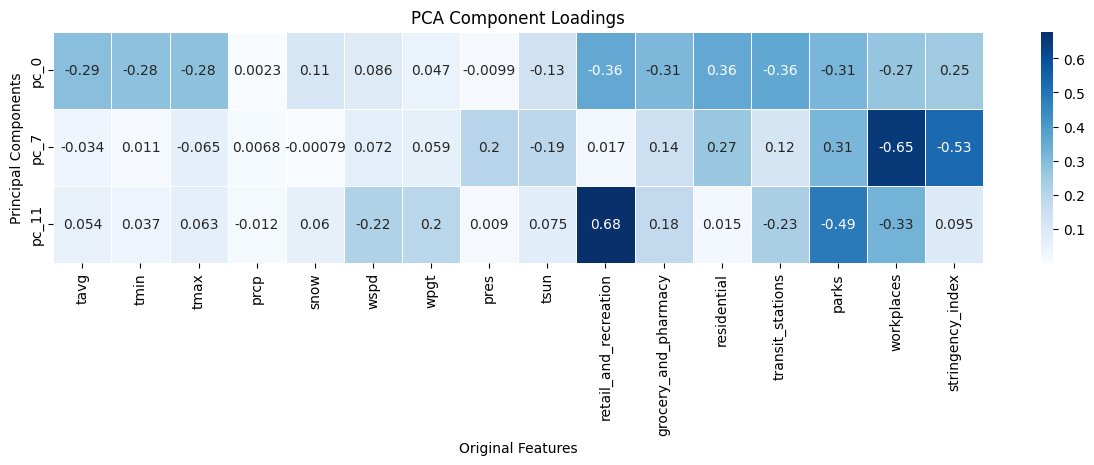

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.instrumental_variable import get_coefficients
from src.models.time_series import get_lagged_df

loadings_dfs = get_lagged_df(
    "media_combined_protest",
    instruments="pc_weather_covid",
    lags=range(-7, 1),
    step=1,
    cumulative=True,
    ignore_group=True,
    ignore_medium=True,
    region_dummies=True,
    return_loadings=True,
)
for loadings_df in loadings_dfs:
    display(loadings_df)
    plt.figure(figsize=(15, 3))
    loadings = loadings_df.iloc[[0, 7, 11]]
    loadings.columns = (
        loadings.columns.str.replace("weather_", "")
        .str.replace("covid_", "")
        .str.replace("_lag0", "")
    )
    sns.heatmap(loadings.abs(), annot=loadings, cmap="Blues", linewidths=0.5)
    plt.title("PCA Component Loadings")
    plt.ylabel("Principal Components")
    plt.xlabel("Original Features")
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

,predictor,coef,ci_lower,ci_upper,wooldridge,anderson_rubin,first_stage_coef,first_stage_ci_lower,first_stage_ci_upper,first_stage_fstat,step,target
0,occ_protest,201.800208,-21.903378,425.503795,NaN,NaN,-0.001360,-0.002784,0.000065,25.593220,0,media_combined_all
1,occ_protest,505.180240,-49.945013,1060.305494,NaN,NaN,-0.001334,-0.002760,0.000092,25.574623,1,media_combined_all
2,occ_protest,830.984430,-34.693034,1696.661895,NaN,NaN,-0.001402,-0.002832,0.000028,25.711939,2,media_combined_all
3,occ_protest,1178.733652,-24.350190,2381.817495,NaN,NaN,-0.001429,-0.002864,0.000007,25.864397,3,media_combined_all
4,occ_protest,1546.165620,-1.438791,3093.770031,NaN,NaN,-0.001456,-0.002895,-0.000018,25.972171,4,media_combined_all


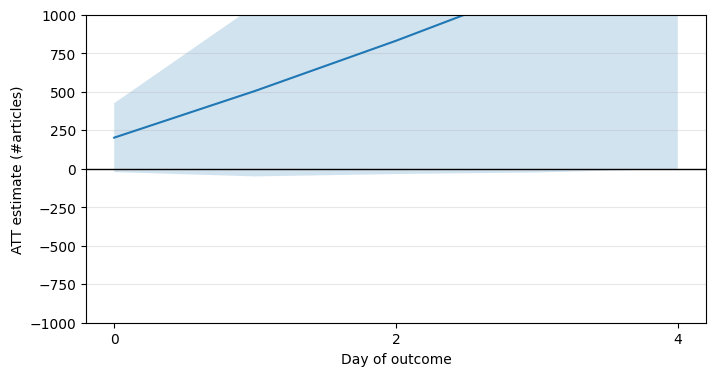

In [1]:
import matplotlib.pyplot as plt

from src.models.time_series import instrumental_variable_liml
from src.visualization.impacts import plot_impact_ts

weather_vars = [
    "weather_prcp_lag0",
    "weather_tavg_lag0",
    "weather_tmax_lag0",
    "weather_tmin_lag0",
    "weather_snow_lag0",
    "weather_wspd_lag0",
    "weather_wpgt_lag0",
    "weather_pres_lag0",
    "weather_tsun_lag0",
]
covid_vars = [
    "covid_retail_and_recreation_lag0",
    "covid_grocery_and_pharmacy_lag0",
    "covid_parks_lag0",
    "covid_residential_lag0",
    "covid_transit_stations_lag0",
    "covid_workplaces_lag0",
    "covid_stringency_index_lag0",
]

target = "media_combined_all"
results = instrumental_variable_liml(
    target=target,
    treatment="occ_protest",
    instruments="pc_weather_covid",
    # instruments_=["pc_resid_3"], # for covid
    # instruments_=["pc_resid_4", "pc_resid_7"], # for weather
    instruments_=["pc_0"],
    lags=range(-7, 1),
    ignore_group=True,
    ignore_medium=True,
    cumulative=True,
    steps=range(0, 5),
    n_jobs=4,
)
display(results)
# results = results.drop(columns=["coef", "ci_lower", "ci_upper"])
# results.columns = results.columns.str.replace("first_stage_", "")
plot_impact_ts(results, "occ_protest", target, ci=True)
plt.ylim(-1000, 1000)

<Axes: >

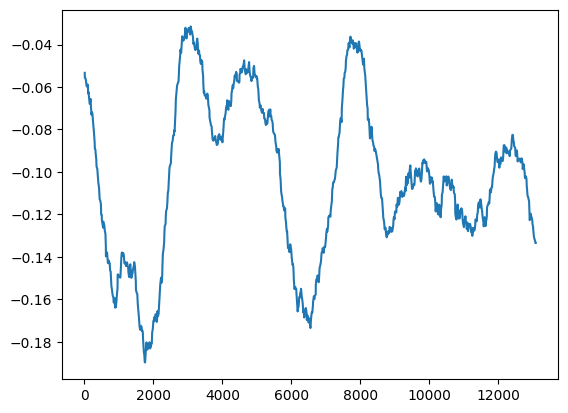

In [ ]:
from src.models.time_series import get_lagged_df

df = get_lagged_df(
    "media_combined_protest",
    instruments="pc_weather_season",
    lags=range(-7, 1),
    step=1,
    cumulative=True,
    ignore_group=True,
    ignore_medium=True,
    region_dummies=True,
)
list(df.columns)
df.query("region_Berlin_lag0 == 1")["pc_seasonal_7"].plot()

In [ ]:
from src.models.instrumental_variable import get_rf_params

rf1, rf2 = get_rf_params()
print(rf1, rf2)
print(rf1 == rf2)

{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200} {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
True


In [ ]:
from src.models.instrumental_variable import check_for_improvement

results = check_for_improvement("weather_")
for clf, (a, b, p) in results.items():
    print(
        f"{clf}: {a.mean():.3f} ± {a.std():.3f} vs {b.mean():.3f} ± {b.std():.3f} -- t-test p={p:.3f}"
    )

LogisticRegression: 0.201 ± 0.057 vs 0.195 ± 0.057 -- t-test p=0.880
RandomForestClassifier: 0.219 ± 0.073 vs 0.213 ± 0.081 -- t-test p=0.761


In [ ]:
results = check_for_improvement("covid_")
for clf, (a, b, p) in results.items():
    print(
        f"{clf}: {a.mean():.3f} ± {a.std():.3f} vs {b.mean():.3f} ± {b.std():.3f} -- t-test p={p:.3f}"
    )

LogisticRegression: 0.201 ± 0.057 vs 0.196 ± 0.058 -- t-test p=0.770
RandomForestClassifier: 0.221 ± 0.073 vs 0.189 ± 0.114 -- t-test p=0.973


  0%|          | 0/28 [00:00<?, ?it/s]

<Axes: xlabel='Shift (days)', ylabel='Coefficient'>

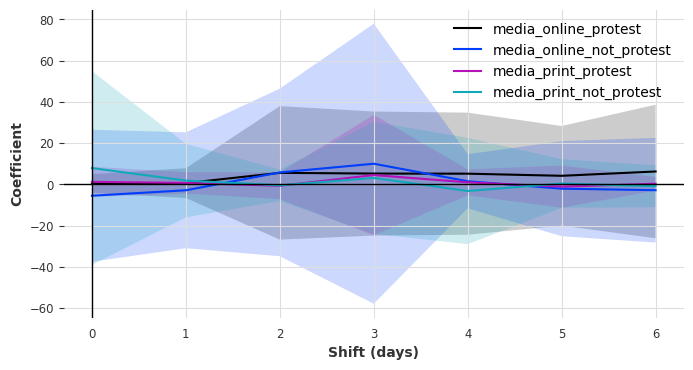

In [ ]:
from src.models.time_series import instrumental_variable_liml, plot_impact_ts

_, results = instrumental_variable_liml(
    target="protest",
    treatment="occ_protest",
    instruments=["weather_prcp"],
    lags=range(-7, 1),
    ignore_group=True,
    n_jobs=1,
)
results
plot_impact_ts(results, "occ_protest")

  0%|          | 0/28 [00:00<?, ?it/s]

<Axes: xlabel='Shift (days)', ylabel='Coefficient'>

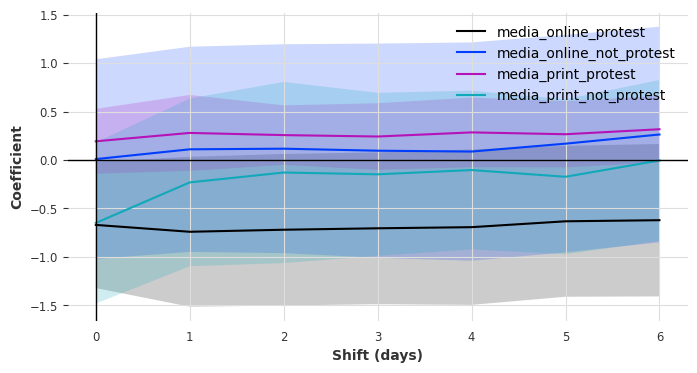

In [ ]:
from src.models.time_series import instrumental_variable_liml, plot_impact_ts

_, results = instrumental_variable_liml(
    target="protest",
    treatment="occ_protest",
    instrument="covid_residential",
    lags=range(-7, 1),
    ignore_group=True,
    n_jobs=1,
)
results
plot_impact_ts(results, "occ_protest")

  0%|          | 0/28 [00:00<?, ?it/s]

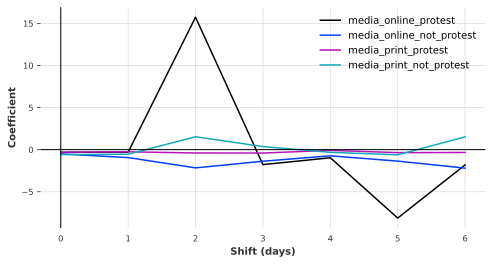

,coef,predictor,ci_lower,ci_upper,sargan,lag,step,target
0,-0.318449,occ_protest,-0.924280,0.287381,0.382231,0,0,media_online_protest
1,-0.300188,occ_protest,-1.680253,1.079877,0.065085,0,1,media_online_protest
2,15.732609,occ_protest,-13281.159234,13312.624453,0.008018,0,2,media_online_protest
3,-1.776222,occ_protest,-12.444097,8.891654,0.016109,0,3,media_online_protest
4,-0.962370,occ_protest,-3.687390,1.762651,0.049779,0,4,media_online_protest
5,-8.128474,occ_protest,-293.253751,276.996803,0.011376,0,5,media_online_protest
6,-1.808921,occ_protest,-6.403043,2.785200,0.052274,0,6,media_online_protest
7,-0.503122,occ_protest,-1.596435,0.590191,0.637404,0,0,media_online_not_protest
8,-0.943247,occ_protest,-4.413367,2.526872,0.037655,0,1,media_online_not_protest
9,-2.164674,occ_protest,-11.805192,7.475845,0.020752,0,2,media_online_not_protest


In [ ]:
from src.models.time_series import instrumental_variable_liml, plot_impact_ts

_, results = instrumental_variable_liml(
    target="protest",
    treatment="occ_protest",
    instruments=[
        "weather_prcp",
        "weather_tavg",
        "weather_tmin",
        "weather_tmax",
        "weather_snow",
        "weather_tsun",
        "weather_wspd",
        "weather_wpgt",
        "weather_pres",
    ],
    lags=range(-7, 1),
    ignore_group=True,
    binarize=True,
    n_jobs=1,
)
plot_impact_ts(results, "occ_protest", ci=False)
plt.show()
results

Sargan-Hansen test:

H0: The instruments are valid, that is they are uncorrelated with the error term of the structural equation.
See: InstrumentalVariablesEstimation2023, sheppardBashtageLinearmodelsRelease2023

In [ ]:
# season-independent params

In [ ]:
# TODO: validation
# res.wooldridge_regression
# res.wooldridge_overid
# res.sargan